本議題所提供之影像資料，包含 6 個類別（正常類別 + 5 種瑕疵類別）。

下載資料 zip 檔案包含：

train_images.zip：訓練所需的影像資料（JPEG格式），共計 5,056 張。
train.csv：包含 2 個欄位，ID 和 Label。
ID：影像的檔名。
Label：瑕疵分類類別（0 表示 normal，1 表示 void，2 表示 horizontal defect，3 表示 vertical defect，4 表示 edge defect，5 表示 particle）。
test_images.zip：測試所需的影像資料（JPEG格式），共計 19,278 張。
test.csv：包含 1 個欄位，ID 。
ID：影像的檔名。
upload_sample.csv:上傳範例。包含 2 個欄位，ID 和 Label。
ID：影像的檔名。
Label：瑕疵分類類別（其值只能是下列其中之一：0、1、2、3、4、5）。

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import sys
import pandas as pd
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print (tf.__version__)

2.4.0


In [ ]:
train_label = pd.read_csv('train.csv')
train_label.head(5)

,ID,Label
0,train_00000.jpg,0
1,train_00001.jpg,1
2,train_00002.jpg,1
3,train_00003.jpg,5
4,train_00004.jpg,5


In [ ]:
filename = train_label['ID'].values
label = train_label['Label'].values

In [ ]:
np.unique(label)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [ ]:
class0 = []
class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for n, element in enumerate(filename):
    if label[n] == 0 :
        class0.append(element)
    if label[n] == 1 :
        class1.append(element)
    if label[n] == 2 :
        class2.append(element)
    if label[n] == 3 :
        class3.append(element)
    if label[n] == 4 :
        class4.append(element)
    if label[n] == 5 :
        class5.append(element)
print (len(class0))
print (len(class1))
print (len(class2))
print (len(class3))
print (len(class4))
print (len(class5))

1348
984
200
756
480
1288


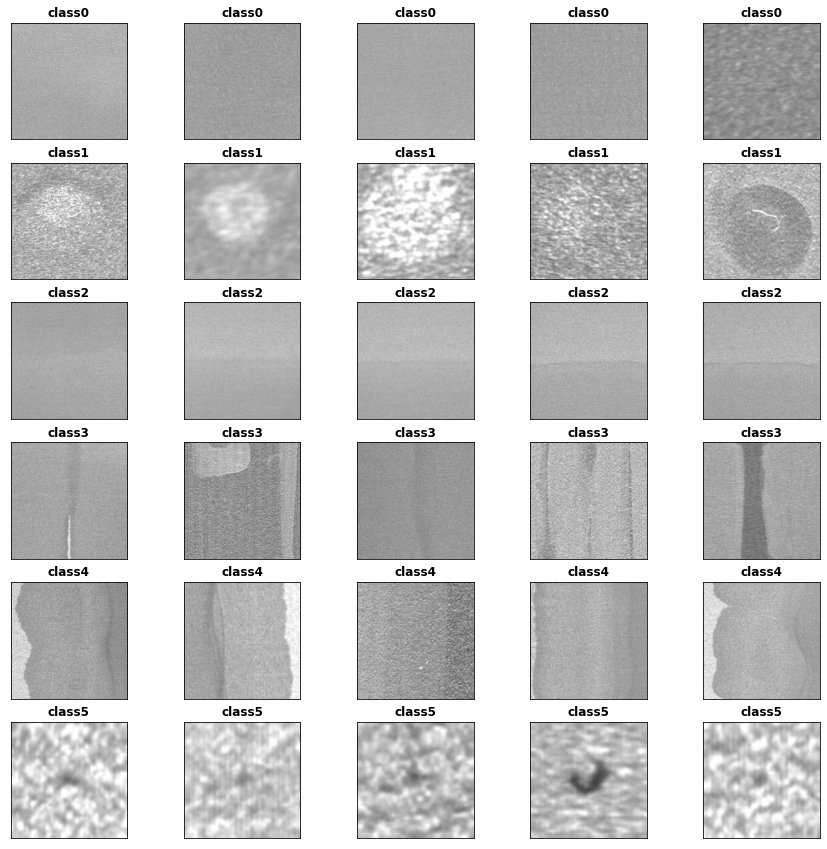

In [ ]:
n = 5
i = 15
plt.figure(figsize=(15,15))
for i in range(n):
    
    ax = plt.subplot(6, n, i +1)
    name = class0[i]
    img = Image.open(f'./train_images/train_images/{name}')
    plt.imshow(img)
    plt.title('class0')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +6)
    name = class1[i]
    img = Image.open(f'./train_images/train_images/{name}')
    plt.imshow(img)
    plt.title('class1')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +11)
    name = class2[i]   
    img = Image.open(f'./train_images/train_images/{name}')
    plt.imshow(img)
    plt.title('class2')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +16)
    name = class3[i]
    img = Image.open(f'./train_images/train_images/{name}')
    plt.imshow(img)
    plt.title('class3')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +21)
    name = class4[i]
    img = Image.open(f'./train_images/train_images/{name}')
    plt.imshow(img)
    plt.title('class4')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +26)
    name = class5[i]
    img = Image.open(f'./train_images/train_images/{name}')
    plt.imshow(img)
    plt.title('class5')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
def readfile(path, labels):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 256, 256, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(256, 256))
        if labels:
            y[i] = int(label[i])
    if labels:
        return x, y
    else:
        return x

In [ ]:
workspace_dir = './train_images/train_images'
print("Reading data")
train_x, train_y = readfile('./train_images/train_images', True)
print("Size of training data = {}".format(len(train_x)))
test_x = readfile('./test_images/test_images', False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 5056
Size of Testing data = 19278


In [ ]:
test_x = test_x/255
train_x = train_x/255

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(train_x, train_y, test_size = 0.2, random_state = 87)

In [ ]:
y_train = tf.one_hot(y_train, 6)
y_validation = tf.one_hot(y_validation, 6)
print (x_train.shape)
print (x_validation.shape)

(4044, 256, 256, 3)
(1012, 256, 256, 3)


In [ ]:
# 資料路徑
DATASET_PATH  = './train_images/train_images'

# 影像大小
IMAGE_SIZE = (256, 256)

# 影像類別數
NUM_CLASSES = 6

# 影像類別名稱
class_names = ['normal', 'void', 'horizontal defect', 'vertical defect', 'edge defect', 'particle']

# 凍結網路層數
FREEZE_LAYERS = 0

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 16

# Epoch 數
NUM_EPOCHS = 200

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

In [ ]:
## 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
conv_base = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
#conv_base.summary()

In [ ]:
#build model
x = conv_base.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(2048,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net = Model(inputs=conv_base.input, outputs=output_layer)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# 設定凍結與要進行訓練的網路層
#conv_base.trainable = False

for layer in net.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net.layers[FREEZE_LAYERS:]:
    layer.trainable = True

print (len(net.trainable_weights))

220


In [ ]:
net.compile(optimizer=Adam(lr=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                             patience=20, verbose=0,mode='auto', baseline=None, 
                                             restore_best_weights=True
                                            )

In [ ]:
history =net.fit(x=x_train,y=y_train,
                 batch_size=BATCH_SIZE,
                 verbose=1,
                 validation_data=(x_validation,y_validation),
                 callbacks=[callback],
                 epochs = NUM_EPOCHS,
                )

Epoch 1/200
253/253 [==============================] - 98s 339ms/step - loss: 0.9182 - accuracy: 0.8055 - val_loss: 515.1416 - val_accuracy: 0.2628
Epoch 2/200
253/253 [==============================] - 81s 319ms/step - loss: 0.1446 - accuracy: 0.9664 - val_loss: 29.0857 - val_accuracy: 0.4002
Epoch 3/200
253/253 [==============================] - 80s 317ms/step - loss: 0.1161 - accuracy: 0.9745 - val_loss: 8.4725 - val_accuracy: 0.2184
Epoch 4/200
253/253 [==============================] - 81s 320ms/step - loss: 0.1245 - accuracy: 0.9686 - val_loss: 1.6412 - val_accuracy: 0.6858
Epoch 5/200
253/253 [==============================] - 82s 324ms/step - loss: 0.0763 - accuracy: 0.9835 - val_loss: 0.1629 - val_accuracy: 0.9447
Epoch 6/200
253/253 [==============================] - 82s 326ms/step - loss: 0.0487 - accuracy: 0.9868 - val_loss: 0.1546 - val_accuracy: 0.9644
Epoch 7/200
253/253 [==============================] - 83s 328ms/step - loss: 0.0406 - accuracy: 0.9935 - val_loss: 0.135

In [ ]:
# 儲存訓練好的模型
net.save(WEIGHTS_FINAL)

In [ ]:
from tensorflow.python.keras.models import load_model
net= load_model(WEIGHTS_FINAL)

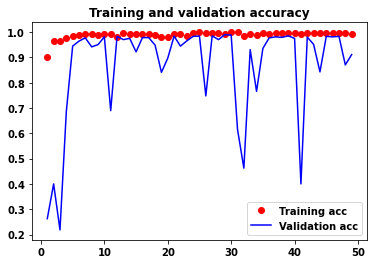

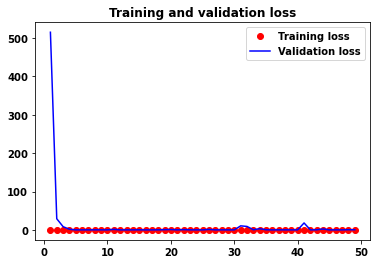

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss,'ro',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
validation_loss,validation_acc = net.evaluate(x_validation,y_validation)
print (validation_loss,validation_acc)

32/32 [==============================] - 10s 152ms/step - loss: 0.1060 - accuracy: 0.9901
0.1060413271188736 0.9901185631752014


In [ ]:
train_loss,train_acc = net.evaluate(x_train,y_train)
print (train_loss,train_acc)

127/127 [==============================] - 18s 139ms/step - loss: 3.6478e-04 - accuracy: 1.0000
0.0003647806588560343 1.0


In [ ]:
vali_pred = net.predict(x_validation)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
true_label = index = tf.argmax(y_validation, axis=1)
predicted_label = index = tf.argmax(vali_pred, axis=1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run ArgMax: Dst tensor is not initialized. [Op:ArgMax]

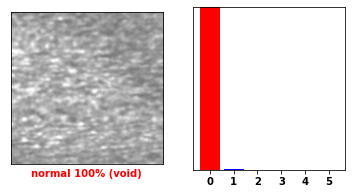

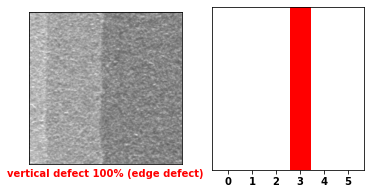

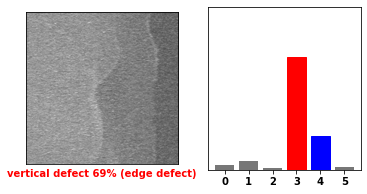

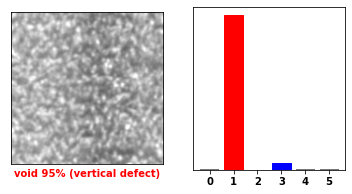

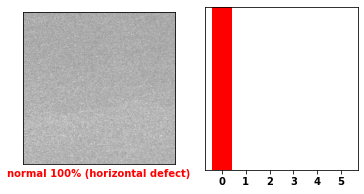

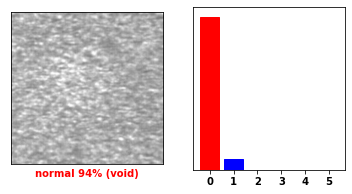

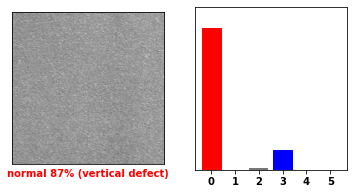

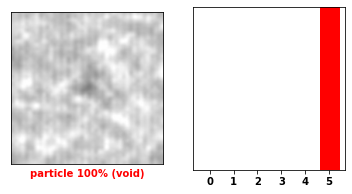

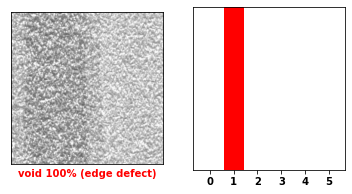

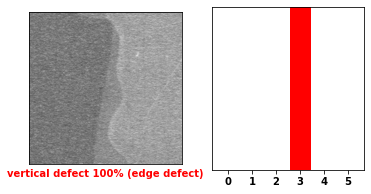

In [ ]:
for i,element in enumerate(true_label) :
    if element != predicted_label[i] :        
        i = i
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plot_image(i, vali_pred[i], y_valid, x_validation)
        plt.subplot(1,2,2)
        plot_value_array(i, vali_pred[i],  y_valid)
        plt.show()


In [ ]:
    name = class5[i]
    img = Image.open(f'./train_images/train_images/{name}')
    plt.imshow(img)
    plt.title('class5')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
predictions = net.predict(test_x)

In [ ]:
print (predictions.shape)
np.argmax(predictions[2])

(19278, 6)


5

In [ ]:
#將結果寫入 CSV 檔
testfilename=os.listdir('./test_images/test_images')
with open('predict.csv','w') as f :
    f.write('ID,Label\n')
    for i, y in enumerate(predictions):
        name = testfilename[i]
        pred = np.argmax(y)
        f.write('{},{}\n'.format(name,pred))